In [1]:
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
import tensorflow.contrib.resampler
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import numpy as np
import cv2
import matplotlib.pyplot as plt
model_dir = "./config/hfnet"
output_frozen_path = "./config/hf_frozen_208x400.pb"

tf.test.is_gpu_available()

ModuleNotFoundError: No module named 'tensorflow.contrib'

In [2]:
class HFNet:
    def __init__(self, model_dir, output_frozen_path):
        self.session = tf.Session()
        self.image_ph = tf.placeholder(tf.float32, shape=(1, 208, 400, 1), name="input_image")
        self.radius_ph = tf.placeholder(tf.int32, name="radius")
        self.k_ph = tf.placeholder(tf.int32, name="k")

        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], model_dir,
            clear_devices=True,
            input_map={
                'image:0': self.image_ph,
                "pred/simple_nms/radius:0": self.radius_ph,
                "pred/top_k_keypoints/k:0": self.k_ph 
                      })

        graph = tf.get_default_graph()

        frozen_graph = tf.graph_util.convert_variables_to_constants(
            self.session, graph.as_graph_def(),
            output_node_names=['global_descriptor', 'keypoints', 'local_descriptors'],
        )
        print("Remove training nodes")
        frozen_graph = tf.graph_util.remove_training_nodes(frozen_graph, ['global_descriptor', 'keypoints', 'local_descriptors'])

        with tf.gfile.GFile(output_frozen_path, mode='wb') as f:
            f.write(frozen_graph.SerializeToString())

hfnet = HFNet(model_dir, output_frozen_path)

INFO:tensorflow:Restoring parameters from ./config/hfnet/variables/variables
INFO:tensorflow:Froze 276 variables.
INFO:tensorflow:Converted 276 variables to const ops.
Remove training nodes


In [2]:
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
import tensorflow.contrib.resampler
from tensorflow.python.compiler.tensorrt import trt_convert as trt

sess =  tf.Session()
# First deserialize your frozen graph:
with tf.gfile.GFile(output_frozen_path, 'rb') as f:
    frozen_graph = tf.GraphDef()
    frozen_graph.ParseFromString(f.read())
# Now you can create a TensorRT inference graph from your
# frozen graph:
converter = trt.TrtGraphConverter(
    input_graph_def=frozen_graph,
    nodes_blacklist=['global_descriptor', 'keypoints', "local_descriptors"], is_dynamic_op=True, precision_mode='FP16') #output nodes
trt_graph = converter.convert()

with tf.gfile.GFile("./config/hf_frozen_trt.pb", mode='wb') as f:
    f.write(trt_graph.SerializeToString())

INFO:tensorflow:Linked TensorRT version: (7, 1, 3)
INFO:tensorflow:Loaded TensorRT version: (7, 1, 0)


In [3]:

outputs = ['global_descriptor', 'keypoints', 'local_descriptors']
o1, o2, o3 = tf.import_graph_def(trt_graph, return_elements=outputs, name="")

g = tf.get_default_graph()
outputs = {n: g.get_tensor_by_name(n+':0')[0] for n in outputs}
input_images = g.get_tensor_by_name("input_image:0")
nms_radius_op = g.get_tensor_by_name('radius:0')
num_keypoints_op = g.get_tensor_by_name('k:0')


In [4]:
#init = tf.initialize_all_variables()
#sess.run(init)
def run(img):
    img = np.expand_dims(img, axis=2)
    img = np.expand_dims(img, axis=0)
    inputs = {
        input_images: img.astype(np.float),
        nms_radius_op: 4,
        num_keypoints_op: 200
    }
    ret = sess.run(outputs, feed_dict=inputs)
    return ret



In [2]:
img = cv2.imread("./db1.jpg")
img2 = cv2.imread("./db1.jpg")
img = cv2.resize(img, (400, 400))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img = img[0:208, 0:400]

29.1 ms ± 883 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


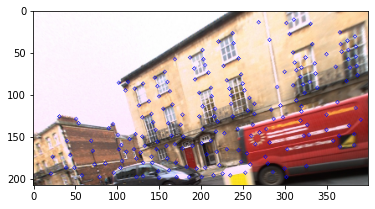

In [5]:
ret = run(img)

%timeit ret = run(img)
img2 = cv2.resize(img2, (400, 400))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)[0:208, 0:400]

for kp in ret["keypoints"]:
    img2 = cv2.circle(img2, (kp[0], kp[1]), 2, (0, 0, 255), 1)
plt.imshow(img2)
    

In [3]:
class HFNet:
    def __init__(self, model_path, outputs):
        self.session = tf.Session()
        self.image_ph = tf.placeholder(tf.float32, shape=(208, 400, 1))

        net_input = self.image_ph[None]
        tf.saved_model.loader.load(
            self.session, [tag_constants.SERVING], str(model_path),
            clear_devices=True,
            input_map={'image:0': net_input})

        graph = tf.get_default_graph()
        self.outputs = {n: graph.get_tensor_by_name(n+':0')[0] for n in outputs}
        self.nms_radius_op = graph.get_tensor_by_name('pred/simple_nms/radius:0')
        self.num_keypoints_op = graph.get_tensor_by_name('pred/top_k_keypoints/k:0')

    
        
    def inference(self, image, nms_radius=4, num_keypoints=1000):
        inputs = {
            self.image_ph: image.astype(np.float),
            self.nms_radius_op: nms_radius,
            self.num_keypoints_op: num_keypoints,
        }
        return self.session.run(self.outputs, feed_dict=inputs)

hfnet = HFNet(model_dir, ['global_descriptor', 'keypoints', 'local_descriptors'])


INFO:tensorflow:Restoring parameters from ./config/hfnet/variables/variables


In [5]:
_img = np.expand_dims(img, axis=2)

ret = hfnet.inference(_img, 4, 200)
%timeit ret = hfnet.inference(_img, 4, 200)

67.1 ms ± 452 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
